# Ksigma CTRV without control-input u

Hier haben wir einen erweiterten Kalman-Filter (EKF) basierend auf dem CTRV-Modell [1] entwickelt und ihn in der Ksigma-Algorithmus zur Berechnung des PL (Protection Level) angewendet.

## Datenvorverarbeitung

In [16]:
%matplotlib widget 
import ast
import numpy as np
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
import pandas as pd
from bagpy import bagreader
from sympy import symbols, Matrix, sin, cos, init_printing
from numpy import array

In [2]:
# import data from recording at Klitten FVZ
results_file = "./Klitten/loc_results_2023-11-01-12-53-52_0.bag"
sensor_file = "./Klitten/recordedData_sensors_locpc_2023-11-01-12-53-52_0.bag"

result_reader = bagreader(results_file)
sensor_reader = bagreader(sensor_file)


# Thius function extracts the sensordata into CSV-files
map_path = result_reader.message_by_topic(topic="/odometry/filtered/map")
# odom_path = result_reader.message_by_topic(topic="/odometry/filtered/odom")
# gps_odometry_path  = result_reader.message_by_topic(topic="/odometry/gps")
imu_oem = sensor_reader.message_by_topic(topic="/localization_pc/can0/decoded/imu")
# speed_oem = sensor_reader.message_by_topic(topic="/localization_pc/can0/decoded/speed")
# steeringAngle_oem = sensor_reader.message_by_topic(topic="/localization_pc/can0/decoded/steeringAngle")
# gnss_oem = sensor_reader.message_by_topic(topic="/localization_pc/can0/decoded/gnss")
# imu_anavs = sensor_reader.message_by_topic(topic="/localization_pc/sensor/anavs/imu")
# navsat_anavs = sensor_reader.message_by_topic(topic="/localization_pc/sensor/anavs/navsat")


# You can then use Pandas to read the files.
df_map_path = pd.read_csv(map_path)  
# df_odom_path = pd.read_csv(odom_path)  
# df_gps_path = pd.read_csv(gps_odometry_path)
# df_speed = pd.read_csv(speed_oem)
df_imu = pd.read_csv(imu_oem)

# 我写的
# df_imu_anavs = pd.read_csv(imu_anavs)
# df_navsat_anvas = pd.read_csv(navsat_anavs)

[INFO]  Data folder ./Klitten/loc_results_2023-11-01-12-53-52_0 already exists. Not creating.
[INFO]  Data folder ./Klitten/recordedData_sensors_locpc_2023-11-01-12-53-52_0 already exists. Not creating.


Die Zeitdaten von `header.stamp.secs` sollen verschoben werden, sodass sie ab 0 Sekunden beginnen.

In [3]:
df_map_path['header.stamp.secs'] = df_map_path['header.stamp.secs'] - df_map_path['header.stamp.secs'].iloc[0]
df_imu['header.stamp.secs'] = df_imu['header.stamp.secs'] - df_imu['header.stamp.secs'].iloc[0]

Die Anzeigeformatierung für DataFrame einstellen

In [4]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_colwidth', 20)

Eine neue Spalte `secs.nsecs` zwischen `header.stamp.secs` und `header.stamp.nsecs` einfügen, sodass der Zeitstempel in Sekunden mit Dezimalstellen dargestellt wird.

In [5]:
# 计算新列
df_imu['secs.nsecs'] = df_imu['header.stamp.secs'] + df_imu['header.stamp.nsecs'] * 1e-9
df_imu['secs.nsecs'] = df_imu['secs.nsecs'].round(9)
# 调整列的位置，将 'secs.nsecs' 放到 'header.stamp.nsecs' 后面
columns = df_imu.columns.tolist()
index = columns.index('header.stamp.nsecs') + 1  # 获取目标列的索引并加1
columns.insert(index, columns.pop(columns.index('secs.nsecs')))  # 移动 secs.nsecs 列

# 重新排列列顺序
df_imu = df_imu[columns]

In [6]:
# 计算新列
df_map_path['secs.nsecs'] = df_map_path['header.stamp.secs'] + df_map_path['header.stamp.nsecs'] * 1e-9
df_map_path['secs.nsecs'] = df_map_path['secs.nsecs'].round(9)
# 调整列的位置，将 'secs.nsecs' 放到 'header.stamp.nsecs' 后面
columns = df_map_path.columns.tolist()
index = columns.index('header.stamp.nsecs') + 1  # 获取目标列的索引并加1
columns.insert(index, columns.pop(columns.index('secs.nsecs')))  # 移动 secs.nsecs 列

# 重新排列列顺序
df_map_path = df_map_path[columns]

## System Design

### Zustand des Modells
Das CTRV-Modell (*Constant Turn Rate and Velocity*) ist ein gängiges Fahrzeugbewegungsmodell, das verwendet wird, um die Bewegung eines Fahrzeugs in Szenarien mit gleichmäßiger Kurvenfahrt zu beschreiben. Es wird angenommen, dass die Kurvendrehgeschwindigkeit (Winkelgeschwindigkeit \( \omega \)) konstant bleibt und die Beschleunigung vernachlässigt wird.
Der Zustandsvektor wird normalerweise definiert als:

$$
\mathbf{x} =
\begin{bmatrix}
x & y & \theta & v & \omega
\end{bmatrix}^\mathsf{T}
$$

- $x, y$: Position des Fahrzeugs im globalen Koordinatensystem
- $\theta$: Orientierung (Fahrtrichtung)
- $v$: Geschwindigkeit
- $\omega$: Winkelgeschwindigkeit/yaw rate

## Zustandsübergangsgleichung

Unter der Annahme eines diskreten Zeitintervalls (\(\Delta t\)) kann der Zustandsübergang wie folgt beschrieben werden:

$$
\mathbf{x}_{k+1} = 
\begin{bmatrix}
x_k + \frac{v_k}{\omega_k} [\sin(\theta_k + \omega_k \Delta t) - \sin(\theta_k)] \\
y_k + \frac{v_k}{\omega_k} [\cos(\theta_k) - \cos(\theta_k + \omega_k \Delta t)] \\
\theta_k + \omega_k \Delta t \\
v_k \\
\omega_k
\end{bmatrix}
$$

Falls $\omega$ = 0, wird die Gleichung für eine gerade Bewegung vereinfacht:

$$
\mathbf{x}_{k+1} = 
\begin{bmatrix}
x_k + v_k \cos(\theta_k) \Delta t \\
y_k + v_k \sin(\theta_k) \Delta t \\
\theta_k \\
v_k \\
\omega_k
\end{bmatrix}
$$


#### Die für die Zustansmatrix (X) erforderlichen Daten aus den Sensordaten extrahieren.

In [119]:
# z, cov_z = func_z(k, dt_step)   

def func_z(k, dt_step):
    t = k * dt_step

    # 从 df_map_path['secs.nsecs'] 中找到与 t 值最接近的值的 index
    idx1                   = (df_map_path['secs.nsecs'] - t).abs().idxmin()
    
    # 获取该 index 对应的测量值
    x                      = df_map_path.loc[idx1, 'pose.pose.position.x']
    y                      = df_map_path.loc[idx1, 'pose.pose.position.y']
    theta                  = df_map_path.loc[idx1, 'pose.pose.orientation.z']
    v                      = df_map_path.loc[idx1, 'twist.twist.linear.x']

    # 获取该 index 对应的测量值的协方差
    cov_pose_str           = df_map_path.loc[idx1, 'pose.covariance']
    cov_pose_parsed_matrix = ast.literal_eval(cov_pose_str)
    cov_pose_matrix        = np.array(cov_pose_parsed_matrix).reshape(6, 6)
    cov_pose               = cov_pose_matrix[0:3, 0:3]  # cov_x, cov_y, cov_xy und cov_theta sind drinnen 

    cov_v_str              = df_map_path.loc[idx1, 'twist.covariance']
    cov_v_parsed_matrix    = ast.literal_eval(cov_v_str)
    cov_v                  = cov_v_parsed_matrix[0]

    # 从 df_imu['secs.nsecs'] 中找到与 t 值最接近的 index
    idx2                   = (df_imu['secs.nsecs'] - t).abs().idxmin()

    # 获取该 index 对应的测量值及其协方差
    omega                  = df_imu.loc[idx2, 'angular_velocity.z']
    cov_omega              = df_imu.loc[idx2, 'angular_velocity_covariance_8']

    # 构建测量矩阵 z 及其方差矩阵 cov_z
    z                      = Matrix([x, y, theta, v, omega])
    cov_z                  = np.zeros((5, 5))  # 创建5x5的零矩阵
    cov_z[:3, :3]          = cov_pose
    cov_z[3, 3]            = cov_v
    cov_z[4, 4]            = cov_omega

    return z, cov_z
    
# k = 10000
# dt_step = 0.1
# z, cov_z = func_z(k, dt_step)   

In [120]:
# Test
k = 10000
dt_step = 0.1
z, cov_z = func_z(k, dt_step)  
# df_map_path.iloc[idx1]

In [121]:
z

Matrix([
[  -719.413248181255],
[    902.60567716048],
[-0.0460239415539503],
[   7.66078025784201],
[ 0.0050614548307835]])

In [122]:
cov_z

array([[7.52127300e-03, 2.60595792e-03, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [2.60595792e-03, 3.41783141e-02, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 4.87015723e-07, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.72327364e-03,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        8.93000000e-04]])

### Prädiktion

In [123]:
from sympy import symbols, Matrix, sin, cos, init_printing
from numpy import array
# x, y, theta, v, omega, time = symbols('x y theta v omega t')

# Jacobian Matrix berechnen
def F_J_evaluated(X, dt): 
    x, y, theta, v, omega, time = symbols('x y theta v omega t')
    subs_FJ = {x:     float(X[0, 0]), 
               y:     float(X[1, 0]), 
               theta: float(X[2, 0]), 
               v:     float(X[2, 0]), 
               omega: float(X[2, 0]), 
               time:  float(dt)}
    if subs_FJ[omega] != 0:
        f_xu = Matrix(
            [x + v/omega * (sin(theta + omega*time) - sin(theta)), 
             y + v/omega * (cos(theta) - cos(theta + omega*time)),  
             theta + omega*time,
             v,
             omega])
    else:
        f_xu = Matrix(
            [x + v * time * cos(theta),
             y + v * time * sin(theta),
             theta,
             v,
             omega])
    F_J = f_xu.jacobian(Matrix([x, y, theta, v, omega])) 
    F_J_evaluated = array(F_J.subs(subs_FJ)).astype(float)
    return F_J_evaluated

def driving(X, dt):
    heading_angle = X[2, 0]
    velocity      = X[3, 0]
    yaw_rate      = X[4, 0]
    
    if yaw_rate != 0:
        radius        = velocity/yaw_rate  # R = v / ω
        beta          = yaw_rate * dt
        dX = np.array([
            [radius * (sin(heading_angle + beta) - sin(heading_angle))],
            [radius * (cos(heading_angle) - cos(heading_angle + beta))],
            [beta],
            [0],
            [0]
        ])
    else:
        dX = np.array([
            [velocity * dt * cos(heading_angle)],
            [velocity * dt * sin(heading_angle)],
            [0],
            [0],
            [0]
        ])

    return X + dX

def predict(X, P, dt):
    predict_X = driving(X=X, dt=dt)
    F = F_J_evaluated(X, dt)
    predict_P = F @ P @ F.T  # 这里还需要构建一个噪声矩阵 Q
    return predict_X, predict_P


#### Test

In [124]:
# Test
k = 10000
dt_step = 0.1
z, cov_z = func_z(k, dt_step) 
predict_X, predict_P = predict(X=z, P=cov_z, dt = dt_step)

In [125]:
predict_X

Matrix([
[ -718.647972479729],
[  902.570625345792],
[-0.045517796070872],
[  7.66078025784201],
[0.0050614548307835]])

In [126]:
z

Matrix([
[  -719.413248181255],
[    902.60567716048],
[-0.0460239415539503],
[   7.66078025784201],
[ 0.0050614548307835]])

In [127]:
predict_P

array([[ 7.55841879e-03,  2.60416145e-03, -1.11669938e-09,
         3.71892368e-04, -1.00842381e-08],
       [ 2.60416145e-03,  3.41784011e-02, -2.27637396e-08,
        -1.79857533e-05, -2.05249200e-07],
       [-1.11669938e-09, -2.27637396e-08,  9.41701572e-06,
         0.00000000e+00,  8.93000000e-05],
       [ 3.71892368e-04, -1.79857533e-05,  0.00000000e+00,
         3.72327364e-03,  0.00000000e+00],
       [-1.00842381e-08, -2.05249200e-07,  8.93000000e-05,
         0.00000000e+00,  8.93000000e-04]])

In [128]:
cov_z

array([[7.52127300e-03, 2.60595792e-03, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [2.60595792e-03, 3.41783141e-02, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 4.87015723e-07, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 3.72327364e-03,
        0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        8.93000000e-04]])

### Update

1. Wenn Sensoren *v* und *ω* direkt messen können, wird empfohlen, den Messwertvektor *z* auf 
   \\([x, y, \theta, v, \omega]^T\\) zu erweitern und gleichzeitig die Beobachtungsmatrix *H* in eine 
   \\(5 \times 5\\)-Einheitsmatrix zu ändern.

2. Wenn die Sensoren *v* und *ω* nicht genau messen können oder die Messwerte stark verrauscht sind, 
   kann die ursprüngliche \\(3 \times 5\\)-Beobachtungsmatrix beibehalten werden. 
   In diesem Fall werden *v* und *ω* indirekt über die Kovarianzausbreitung aktualisiert.

In [131]:
# H = Matrix([[1, 0, 0, 0, 0], 
#             [0, 1, 0, 0, 0],
#             [0, 0, 1, 0, 0]])

H = Matrix([[1, 0, 0, 0, 0], 
            [0, 1, 0, 0, 0],
            [0, 0, 1, 0, 0], 
            [0, 0, 0, 1, 0],
            [0, 0, 0, 0, 1]])
H

Matrix([
[1, 0, 0, 0, 0],
[0, 1, 0, 0, 0],
[0, 0, 1, 0, 0],
[0, 0, 0, 1, 0],
[0, 0, 0, 0, 1]])

In [135]:
def h_x(X):
    """convert prediction to measurement"""
    h_x = H @ X
    return h_x
    
# Test
k = 10000
dt_step = 0.1
z, cov_z = func_z(k-1, dt_step) 
predict_X, predict_P = predict(X=z, P=cov_z, dt = dt_step)
hx = h_x(predict_X)
z, cov_z = func_z(k, dt_step) 
hx

Matrix([
[  -719.532852065376],
[   902.614110642464],
[-0.0463798539463329],
[   7.66725556116766],
[ 0.0047123889803846]])

In [136]:
# Roger R Labbe Jr. Kalman_and_Bayesian_Filters_in_Python.
def residual(z, hx):
    """ compute residual (a-b) between measurements containing 
    [x, y, theta, v, omega]. theta is normalized to [-pi, pi)"""
    y = z - hx
    y[2] = y[2] % (2 * np.pi)    # force in range [0, 2*pi)
    if y[2] > np.pi:             # move to [-pi, pi)
        y[2] -= 2 * np.pi
    return y
y = residual(z, hx)
y

Matrix([
[   0.119603884121034],
[-0.00843348198452532],
[ 0.00035591239238264],
[-0.00647530332564639],
[  0.0003490658503989]])

In [ ]:
# 这个函数可以不要了，因为 cov_z 就是 R
# Measurement Noise Matrix
# def R_matrix(k, dt_step):
#     z, cov_z          = func_z(k, dt_step)                    # func_z用来获取测量值和每次更新阶段时刻k所需的最新状态矩阵 X 的噪声协方差
#     cov_x             = cov_z[0]
#     cov_y             = cov_z[1]
#     cov_xy            = cov_z[2]
#     cov_theta         = cov_z[3]
#     
#     # Measurement Noise Matrix，在不重新定义整个 EKF 实例 的情况下，动态更新测量噪声协方差矩阵 R。直接在循环中动态修改 ekf.R 即可，而无需重新实例化扩展卡尔曼滤波器。这种方式既高效又灵活。
#     diagonal_elements = [cov_x, cov_y, cov_theta]             # 对角元素
#     R                 = np.diag(diagonal_elements)
#     R[0, 1]           = cov_xy
#     R[1, 0]           = cov_xy
#     return R

In [137]:
def update(X, P, k, dt_step):
    X_p      = X
    P_p      = P
    
    # calculate residual y
    z, cov_z = func_z(k, dt_step)
    hx       = h_x(X_p)
    y        = residual(z, hx)

    # Kalman Gain Matrix
    R        = cov_z
    S        = H @ P_p @ H.T + R  # 残差协方差
    K        = P_p @ H.T @ S.inv()  # 卡尔曼增益矩阵

    X_update = X_p + K @ y
    I        = np.eye(5)  # 后期这个 5 可以设置为一个名为 dim 的变量，就不用单独来到这里修改了  
    P_update = (I - K @ H) @ P_p
    
    return X_update, P_update

In [153]:
# Test
k = 1000
dt_step = 0.2
X, P = func_z(k-1, dt_step) 
predict_X, predict_P = predict(X, P, dt=dt_step)
X_update, P_update = update(X=predict_X, P=predict_P, k=k, dt_step=dt_step)
z, cov_z = func_z(k, dt_step)

In [154]:
X

Matrix([
[   -267.19912263889],
[   494.298042140672],
[  0.881628503119708],
[    8.3261414012789],
[-0.0022689280275926]])

In [155]:
predict_X

Matrix([
[  -266.139920490868],
[   495.582984157809],
[   0.88117471751419],
[    8.3261414012789],
[-0.0022689280275926]])

In [156]:
z

Matrix([
[  -268.111067495898],
[   495.605073101805],
[  0.880910469662697],
[   8.33103682887618],
[-0.0034906585039886]])

In [157]:
X_update

Matrix([
[    -267.10016625878],
[    495.592286383149],
[   0.880929968976011],
[    8.26832166828146],
[-0.00354719244950499]])

In [ ]:
X_p, P_p = predict(X=X_0, P=P_0, u=u_0, cov_u=cov_u0, dt=dt_step)  # 这里的 X，P 是 k 时刻的先验估计值，也就是 k+1 时刻预测值
X_p

In [ ]:
P_p

In [ ]:
X_update, P_update = update(X_p, P_p, k, dt_step)

In [ ]:
X_update

In [ ]:
P_update

In [ ]:
"""def update(X, P, k, dt_step):
    X_p      = X
    P_p      = P
    # calculate residual y
    z, cov_z = func_z(k, dt_step)
    hx       = h_x(X_p)
    y        = residual(z, hx)

    # Kalman Gain Matrix
    u, cov_u = func_u(k, dt_step)
    R        = R_matrix(k, dt_step)
    S        = H @ P_p @ H.T + R  # 残差协方差
    K        = P_p @ H.T @ S.inv()  # 卡尔曼增益矩阵

    X_update = X_p + K @ y
    I        = np.eye(3)
    P_update = (I - K @ H) @ P_p

    # 将所有中间变量打包到字典
    intermediate_vars = {
        "X_p": X_p,
        "P_p": P_p,
        "z": z,
        "cov_z": cov_z,
        "hx": hx,
        "y": y,
        "u": u,
        "cov_u": cov_u,
        "R": R,
        "S": S,
        "K": K,
        "X_update": X_update,
        "I": I,
        "P_update": P_update,
    }
    intermediate_series = pd.Series(intermediate_vars)
    
    return X_update, P_update, intermediate_series
X_update, P_update, intermediate_series = update(X_p, P_p, k, dt_step)""" 

In [ ]:
"""X_update"""

In [ ]:
"""P_update"""

In [ ]:
"""for key, value in intermediate_series.items():
    print(f"{key}:\n{value}\n")"""

In [ ]:
# Beispiel
k = 400
dt_step = 0.5
z, cov_z = func_z(k-1, dt_step)
X_0 = z.copy()  # 当作 k-1 时刻的最优估计值
u_0, cov_u0 = func_u(k-1, dt_step)

In [ ]:
X_0

In [ ]:
P_0 = np.diag([.1, .1, .1])  # 当作 k-1 时刻 P 的最优估计值
P_0

In [ ]:
X_p, P_p = predict(X=X_0, P=P_0, u=u_0, cov_u=cov_u0, dt=dt_step)  # 这里的 X，P 是 k 时刻的先验估计值，也就是 k+1 时刻预测值
X_p

In [ ]:
P_p

In [ ]:
z, cov_z = func_z(k, dt_step)  # 这里是 k 时刻的传感器测量值
z

calculate measurement from system state

In [ ]:
hx = h_x(X_p)
hx

In [ ]:
y = residual(z, hx)
y

In [ ]:
R = R_matrix(k, dt_step)
R

In [ ]:
def calculate_K(P, H, R):
    """
    计算卡尔曼增益矩阵 K
    """
    # 计算中间结果
    S = H @ P @ H.T + R  # 残差协方差
    K = P @ H.T @ S.inv()  # 卡尔曼增益矩阵
    return K
K = calculate_K(P_p, H, R)
K

In [ ]:
X_update = X_p + K @ y
X_update

In [ ]:
I = np.eye(3)
I

In [ ]:
P_update = (I - K @ H) @ P_p
P_update

## run

### code

In [163]:
import os
from filterpy.stats import plot_covariance_ellipse
def run_CTRV_EKF(dt_step      = 0.5,             # secs, dt不可以直接指定固定值，而是要根据测量数据的时间戳进行决定，或者确定一个dt，截取传感器数据中与之时刻最接近的数据
                 dt_track     = 0.1,
                 sim_duration = 20,              # secs
                 ylim         = None):
    plt.clf()                                    # 清除上一次运行所绘图像
    z_0, cov_z0  = func_z(k=0, dt_step=dt_step)
    X            = z_0.copy()                    # X_0
    P            = cov_z0.copy()                 # P_0, 之后也可以给P_0写一个函数，这里先这么着吧
    # u, cov_u     = func_u(k=0, dt_step=dt_step)  # u_0, cov_u0
    track        = []                            # 用于记录汽车的运行轨迹
    k            = 0                             # timestep for prediction and update
    sim_X        = z_0.copy()
    step         = int(dt_step / dt_track)                            
    ellipse_step = 10 * step
    track_step   = int(sim_duration / dt_track)

    # k_met = False                                # 第一次的Kovarianz太大，可以不画椭圆
                                                 # 但是对于不含u的CTRV而言是否需要k_met还需斟酌
    for i in range(track_step):
            
        # driving(X, u, dt)
        sim_X = driving(sim_X, dt_track)                          # simulate the driving model of the car
        track.append(sim_X)                                       # 这里并不多余，因为要绘制汽车运行的轨迹图，当 ω ≠ 0 时，两次更新点之间的轨迹并不是一条直线，所以需要适当的增加一些轨迹点使轨迹图看起来平滑

        # 判断是否需要设置 k_met 为 True
        # if not k_met and k <= 10:
        #     k_met = True
        
        if i % step == 0:
            k         = k + 1
            # u, cov_u  = func_u(k, dt_step)                            # func_u是用来获取在每次更新阶段时刻k所需的最新控制矩阵 u，现在还每写，等ekf框架搭建完成后再设计  
            # cov_v     = cov_u[0]
            # cov_omega = cov_u[1]
            X, P = predict(X, P, dt=dt_step)  # predict

            if i % ellipse_step == 0:
            # if i % ellipse_step == 0 and k >= 10:
                plot_covariance_ellipse(
                    (X[0,0], X[1,0]), P[0:5, 0:5], 
                    std=1, facecolor='k', alpha=0.3)                 # 设置predict阶段的协方差椭圆的颜色为黑色，透明度为 0.3（范围是 0 到 1）

            X, P = update(X=X, P=P, k=k, dt_step=dt_step)  # update
            P = np.array(P.tolist(), dtype=float)  # from "type: <class 'sympy.matrices.dense.MutableDenseMatrix'>" to "type: <class 'numpy.ndarray'>"
            
            if i % ellipse_step == 0:
            # if i % ellipse_step == 0 and k >= 10:
                plot_covariance_ellipse(
                    (X[0,0], X[1,0]), P[0:5, 0:5], 
                     std=1, facecolor='g', alpha=0.8)
                
            # print(f'P_{k}:{P}:')  # 测试完成后删除
            
            sim_X = X
            track.append(sim_X)    
        if i == track_step - 1:  # testcode, should be deleted after testing
            print(f'Pu_{k}:{P}:')
        
    track = np.array(track)  # 假设 track 是您的轨迹数据
    plt.plot(track[:, 0], track[:, 1], color='k', lw=2)
    plt.axis('equal')
    plt.grid(True)

    # 设置动态标题
    title_text = f"Klitten EKF\nsim_duration = {sim_duration}, dt_step = {dt_step}, dt_track = {dt_track}"
    plt.title(title_text)
    if ylim is not None:
        plt.ylim(*ylim)

    # 动态生成文件夹路径
    save_dir = "C:/Users/wq138/OneDrive - mailbox.tu-dresden.de/Diplomarbeit/sim_Ergebnisse/"
    os.makedirs(save_dir, exist_ok=True)

    # 生成基础文件名
    base_name = f"Klitten_EKF_sim_duration={sim_duration}_dt_step={dt_step}_dt_track={dt_track}"
    file_extension = ".png"

    # 初始化计数器为 1
    counter = 1
    save_path = os.path.join(save_dir, f"{base_name}({counter}){file_extension}")

    # 检查文件是否已存在，如果存在递增计数器
    while os.path.exists(save_path):
        counter += 1
        save_path = os.path.join(save_dir, f"{base_name}({counter}){file_extension}")

    # 保存图片
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Chart has been saved in: {save_path}")

    return 
# 图像大小还需要调整，貌似每次都会被上一次的数据覆盖


Pu_1000:[[ 1.25152033e-05 -4.12590337e-07  9.90208915e-09 -4.53158316e-08
   8.87007170e-11]
 [-4.12590337e-07  2.00554047e-05 -6.65487853e-08 -7.80538770e-09
  -2.25869902e-10]
 [ 9.90208915e-09 -6.65487853e-08  4.55966818e-10  1.07831873e-10
   2.16207128e-12]
 [-4.53158316e-08 -7.80538770e-09  1.07831873e-10  2.78198442e-10
   4.48647944e-13]
 [ 8.87007170e-11 -2.25869902e-10  2.16207128e-12  4.48647944e-13
   1.14361248e-14]]:


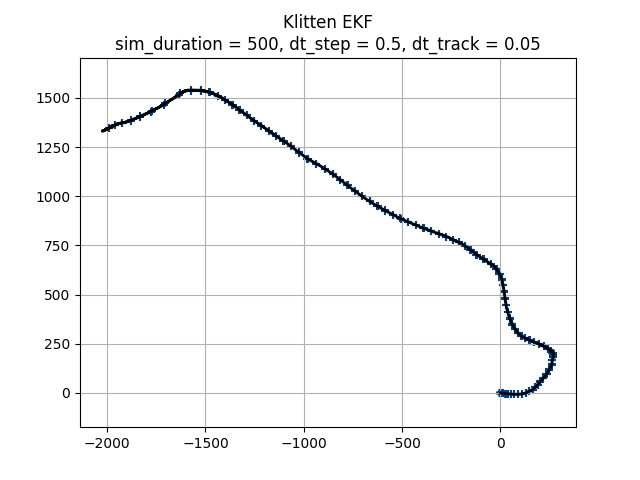

Chart has been saved in: C:/Users/wq138/OneDrive - mailbox.tu-dresden.de/Diplomarbeit/sim_Ergebnisse/Klitten_EKF_sim_duration=500_dt_step=0.5_dt_track=0.05(4).png


In [164]:
run_CTRV_EKF(sim_duration = 500, dt_step = 0.5, dt_track = 0.05)

### Testcode

# 4. Design Measurement Noise

# 5. Implementation

If the curve above is the process model, then the dotted lines shows the linearization of that curve for the estimate $x=1.5$.

We linearize systems by taking the derivative, which finds the slope of a curve:

$$\begin{aligned}
f(x) &= x^2 -2x \\
\frac{df}{dx} &= 2x - 2
\end{aligned}$$

and then evaluating it at $x$:

$$\begin{aligned}m &= f'(x=1.5) \\&= 2(1.5) - 2 \\&= 1\end{aligned}$$ 

Linearizing systems of differential equations is similar. We linearize $f(\mathbf x, \mathbf u)$, and $h(\mathbf x)$ by taking the partial derivatives of each to evaluate $\mathbf F$ and $\mathbf H$ at the point $\mathbf x_t$ and $\mathbf u_t$. We call the partial derivative of a matrix the [*Jacobian*](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant). This gives us the the discrete state transition matrix and measurement model matrix:

$$
\begin{aligned}
\mathbf F 
&= {\frac{\partial{f(\mathbf x_t, \mathbf u_t)}}{\partial{\mathbf x}}}\biggr|_{{\mathbf x_t},{\mathbf u_t}} \\
\mathbf H &= \frac{\partial{h(\bar{\mathbf x}_t)}}{\partial{\bar{\mathbf x}}}\biggr|_{\bar{\mathbf x}_t} 
\end{aligned}
$$

This leads to the following equations for the EKF. I put boxes around the differences from the linear filter:

$$\begin{array}{l|l}
\text{linear Kalman filter} & \text{EKF} \\
\hline 
& \boxed{\mathbf F = {\frac{\partial{f(\mathbf x_t, \mathbf u_t)}}{\partial{\mathbf x}}}\biggr|_{{\mathbf x_t},{\mathbf u_t}}} \\
\mathbf{\bar x} = \mathbf{Fx} + \mathbf{Bu} & \boxed{\mathbf{\bar x} = f(\mathbf x, \mathbf u)}  \\
\mathbf{\bar P} = \mathbf{FPF}^\mathsf{T}+\mathbf Q  & \mathbf{\bar P} = \mathbf{FPF}^\mathsf{T}+\mathbf Q \\
\hline
& \boxed{\mathbf H = \frac{\partial{h(\bar{\mathbf x}_t)}}{\partial{\bar{\mathbf x}}}\biggr|_{\bar{\mathbf x}_t}} \\
\textbf{y} = \mathbf z - \mathbf{H \bar{x}} & \textbf{y} = \mathbf z - \boxed{h(\bar{x})}\\
\mathbf{K} = \mathbf{\bar{P}H}^\mathsf{T} (\mathbf{H\bar{P}H}^\mathsf{T} + \mathbf R)^{-1} & \mathbf{K} = \mathbf{\bar{P}H}^\mathsf{T} (\mathbf{H\bar{P}H}^\mathsf{T} + \mathbf R)^{-1} \\
\mathbf x=\mathbf{\bar{x}} +\mathbf{K\textbf{y}} & \mathbf x=\mathbf{\bar{x}} +\mathbf{K\textbf{y}} \\
\mathbf P= (\mathbf{I}-\mathbf{KH})\mathbf{\bar{P}} & \mathbf P= (\mathbf{I}-\mathbf{KH})\mathbf{\bar{P}}
\end{array}$$

We don't normally use $\mathbf{Fx}$ to propagate the state for the EKF as the linearization causes inaccuracies. It is typical to compute $\bar{\mathbf x}$ using a suitable numerical integration technique such as Euler or Runge Kutta. Thus I wrote $\mathbf{\bar x} = f(\mathbf x, \mathbf u)$. For the same reasons we don't use $\mathbf{H\bar{x}}$ in the computation for the residual, opting for the more accurate $h(\bar{\mathbf x})$.

I think the easiest way to understand the EKF is to start off with an example. Later you may want to come back and reread this section.